In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### RNNの活用例を知る 機械翻訳　Sequence to Sequence イメージキャプショニング

## 【問題1】機械翻訳の実行とコードリーディング
Keras公式のサンプルコードで、短い英語からフランス語への変換が行えるのでこれを動かしてください。
その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。
https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py

（例）

51から56行目 : ライブラリのimport

58から63行目 : ハイパーパラメータの設定

66から84:データを読み込み整形、含まれる文字種類のリスト作成

86から123: 文字数、シーケンス長さの取得、入力データの作成、文字をワンホット化

125から148: モデルの構築　エンコーダーLSTM、デコーダーLSTM、全結合層、softmax、デコーダーの初期値としてエンコーダーのcとhを渡している

149から154: トレーニングとモデルのセーブ。入力は英語のシーケンスとフランス語のシーケンス。decoder_input_dataは開始文字から始まり終了文字で終わる。

165から: predict用にモデルを構築、デコーダー側の予測結果を次のシーケンスの入力に回している

In [0]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n') #テキストを１行ずつのリストにしている
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t') #タブ分けで１行を英語とフランス語に分けている
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:  #input_charactersに英語データに使用している文字の全種類を格納
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters: #target_charactersにフランス語データに使用している文字の全種類を格納
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.　#開始文字から
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1. #targetdataは開始文字は含めない

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 69
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 108s 14ms/step - loss: 0.9208 - val_loss: 0.9710
Epoch 2/100
8000/8000 [==============================] - 122s 15ms/step - loss: 0.7320 - val_loss: 0.7736
Epoch 3/100
8000/8000 [==============================] - 106s 13ms/step - loss: 0.6214 - val_loss: 0.6945
Epoch 4/100
8000/8000 [==============================] - 97s 12ms/step - loss: 0.5645 - val_loss: 0.6558
Epoch 5/100
8000/8000 [==============================] - 97s 12ms/step - loss: 0.5266 - val_loss: 0.6066
Epoch 6/100
8000/8000 [==============================] - 100s 13ms/step - loss: 0.4939 - val_loss: 0.5849
Epoch 7/100
8000/8000 [==============================] - 106s 13ms/step - loss: 0.4671 - val_loss: 0.5567
Epoch 8/100
8000/8000 [========================

Epoch 76/100
8000/8000 [==============================] - 98s 12ms/step - loss: 0.0806 - val_loss: 0.6682
Epoch 77/100
8000/8000 [==============================] - 103s 13ms/step - loss: 0.0787 - val_loss: 0.6735
Epoch 78/100
8000/8000 [==============================] - 100s 12ms/step - loss: 0.0774 - val_loss: 0.6707
Epoch 79/100
8000/8000 [==============================] - 103s 13ms/step - loss: 0.0763 - val_loss: 0.6783
Epoch 80/100
8000/8000 [==============================] - 103s 13ms/step - loss: 0.0752 - val_loss: 0.6771
Epoch 81/100
8000/8000 [==============================] - 100s 12ms/step - loss: 0.0736 - val_loss: 0.6922
Epoch 82/100
8000/8000 [==============================] - 98s 12ms/step - loss: 0.0727 - val_loss: 0.6816
Epoch 83/100
8000/8000 [==============================] - 114s 14ms/step - loss: 0.0717 - val_loss: 0.6910
Epoch 84/100
8000/8000 [==============================] - 110s 14ms/step - loss: 0.0706 - val_loss: 0.6904
Epoch 85/100
8000/8000 [===============

/Users/morio/.pyenv/versions/anaconda3-5.3.0/envs/python-ml/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Wow!
Decoded sentence: Ça alors !

-
Input sentence: Fire!
Decoded sentence: Au feu !

-
Input sentence: Help!
Decoded sentence: À l'aide !

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Go on.
Decoded sentence: Continuez.

-
Input sentence: Go on.
Decoded sentence: Continuez.

-
Input sentence: Go on.
Decoded sentence: Continuez.

-
Input sentence: Hello!
Decoded sentence: Salut !

-
Input sentence: Hello!
Decoded sentence: Salut !

-
Input sentence: I see.
Decoded sentence: Je voy

## 3.イメージキャプショニング
他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。これは画像を入力し、時系列を出力するImage to Sequenceの手法によって行えます。
イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。
https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning
## 【問題2】イメージキャプショニングの学習済みモデルの実行
上記実装において5. Test the modelの項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。

データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。

注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。



In [0]:
!git clone https://github.com/pdollar/coco.git

fatal: destination path 'coco' already exists and is not an empty directory.


In [0]:
cd coco/PythonAPI

/content/coco/PythonAPI


In [0]:
!make

python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/coco/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.6/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:

In [0]:
!python setup.py build

running build
running build_py
creating build
creating build/lib.linux-x86_64-3.6
creating build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/coco.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/__init__.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/mask.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/cocoeval.py -> build/lib.linux-x86_64-3.6/pycocotools
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
building 'pycocotools._mask' extension
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.6/../common/maskApi.o -Wno-cpp -Wno-unused-func

In [0]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating pycocotools.egg-info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/coco.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/_mask.cpython-36m-x86_64-linux-gnu.so -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/__init__

In [0]:
cd ../../

/content


In [0]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

fatal: destination path 'pytorch-tutorial' already exists and is not an empty directory.


In [0]:
cd pytorch-tutorial/tutorials/03-advanced/image_captioning

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [0]:
pip install -r requirements.txt

In [0]:
!chmod +x download.sh

In [0]:
!./download.sh

Output hidden; open in https://colab.research.google.com to view.

In [34]:
!python build_vocab.py

loading annotations into memory...
Done (t=1.01s)
creating index...
index created!
Traceback (most recent call last):
  File "build_vocab.py", line 76, in <module>
    main(args)
  File "build_vocab.py", line 58, in main
    vocab = build_vocab(json=args.caption_path, threshold=args.threshold)
  File "build_vocab.py", line 36, in build_vocab
    tokens = nltk.tokenize.word_tokenize(caption.lower())
  File "/usr/local/lib/python3.6/dist-packages/nltk/tokenize/__init__.py", line 128, in word_tokenize
    sentences = [text] if preserve_line else sent_tokenize(text, language)
  File "/usr/local/lib/python3.6/dist-packages/nltk/tokenize/__init__.py", line 94, in sent_tokenize
    tokenizer = load('tokenizers/punkt/{0}.pickle'.format(language))
  File "/usr/local/lib/python3.6/dist-packages/nltk/data.py", line 834, in load
    opened_resource = _open(resource_url)
  File "/usr/local/lib/python3.6/dist-packages/nltk/data.py", line 952, in _open
    return find(path_, path + ['']).open()
  Fil

In [0]:
!python resize.py

In [36]:
pwd

'/content/pytorch-tutorial/tutorials/03-advanced/image_captioning'

In [0]:
!mkdir models

In [40]:
cd models

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning/models


In [41]:
from google.colab import files
uploaded = files.upload()

Saving pretrained_model.zip to pretrained_model.zip


In [42]:
!unzip pretrained_model.zip

Archive:  pretrained_model.zip
  inflating: encoder-5-3000.pkl      
  inflating: decoder-5-3000.pkl      


In [44]:
cd ../

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [45]:
cd data

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning/data


In [46]:
from google.colab import files
uploaded = files.upload()

Saving vocap.zip to vocap.zip


In [47]:
!unzip vocap.zip

Archive:  vocap.zip
  inflating: vocab.pkl               


In [48]:
cd ../

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [59]:
pwd

'/content/pytorch-tutorial/tutorials/03-advanced/image_captioning'

In [60]:
!python sample.py --image "data/resized2014/COCO_train2014_000000000034.jpg" --encoder_path 'models/encoder-5-3000.pkl'  --decoder_path 'models/decoder-5-3000.pkl'

<start> a zebra is standing in a field with a tree . <end>


In [0]:
path = "data/resized2014/COCO_train2014_000000000034.jpg"

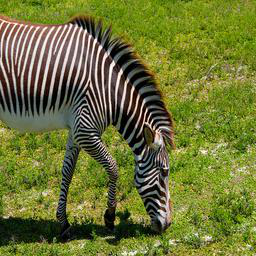

In [63]:
from PIL import Image
img = Image.open(path)
img
#predict結果：a zebra is standing in a field with a tree　木ではないがシマウマが立っているというのは当たってますね

In [75]:
!wget https://static-maquia.hpplus.jp/upload/image/manager/25/EJdXgSI-1200.jpg -O gazo2.jpg 

--2019-03-30 07:32:38--  https://static-maquia.hpplus.jp/upload/image/manager/25/EJdXgSI-1200.jpg
Resolving static-maquia.hpplus.jp (static-maquia.hpplus.jp)... 13.35.115.99, 13.35.115.8, 13.35.115.96, ...
Connecting to static-maquia.hpplus.jp (static-maquia.hpplus.jp)|13.35.115.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 320968 (313K) [image/jpeg]
Saving to: ‘gazo2.jpg’

gazo2.jpg           100%[===================>] 313.45K   478KB/s    in 0.7s    

2019-03-30 07:32:40 (478 KB/s) - ‘gazo2.jpg’ saved [320968/320968]



In [78]:
!python sample.py --image "gazo.jpg" --encoder_path 'models/encoder-5-3000.pkl'  --decoder_path 'models/decoder-5-3000.pkl'

<start> a woman is holding a cell phone in her hand . <end>


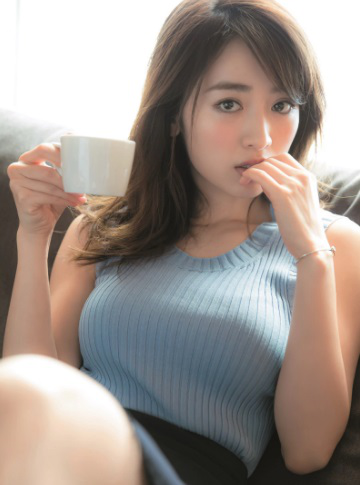

In [79]:
from PIL import Image
path = "gazo.jpg"
img = Image.open(path)
img
#predict結果：a woman is holding a cell phone in her hand 

##【問題3】Kerasで動かしたい場合はどうするかを調査
参考https://qiita.com/koppe/items/7f85f5411539390c4499
MMdnnというライブラリがあるので変換が可能です。
問題があったら下をみると良い
https://github.com/Microsoft/MMdnn/blob/master/mmdnn/conversion/pytorch/README.md

自分で変換するときは、変換元、先の形式を確認し変換するコンバーターを作成する必要がある

下で色々やってますができてないので無視してください

In [80]:
pip install mmdnn

    100% |████████████████████████████████| 317kB 24.0MB/s 
    100% |████████████████████████████████| 17.3MB 1.6MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import os
from torchvision import transforms
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from PIL import Image

model = EncoderCNN(256).eval() 
model.load_state_dict(torch.load('models/encoder-5-3000.pkl'))
torch.save(model, "encoder_test.pth")

In [0]:
m_1 = torch.load("encoder_test.pth")

In [83]:
!mmdownload -f keras

Using TensorFlow backend.
Support frameworks: {'inception_v3', 'nasnet', 'densenet', 'yolo2', 'inception_resnet_v2', 'mobilenet', 'resnet50', 'xception', 'vgg16', 'vgg19'}


In [101]:
!mmconvert -sf pytorch -iw encoder_test.pth -df keras -om encoder-5-3000.h5

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mmdnn/conversion/pytorch/pytorch_parser.py", line 76, in __init__
    model = torch.load(model_file_name)
  File "/usr/local/lib/python3.6/dist-packages/torch/serialization.py", line 368, in load
    return _load(f, map_location, pickle_module)
  File "/usr/local/lib/python3.6/dist-packages/torch/serialization.py", line 542, in _load
    result = unpickler.load()
ModuleNotFoundError: No module named 'model'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/mmconvert", line 10, in <module>
    sys.exit(_main())
  File "/usr/local/lib/python3.6/dist-packages/mmdnn/conversion/_script/convert.py", line 102, in _main
    ret = convertToIR._convert(ir_args)
  File "/usr/local/lib/python3.6/dist-packages/mmdnn/conversion/_script/convertToIR.py", line 92, in _convert
    parser = PytorchParser(model, inputshape[0])
  File "/usr/local/li

## 【問題4】（アドバンス課題）コードリーディングと書き換え

In [0]:
#元のコード

import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1) #dim=1のコンカット　unsqueeze次元の追加
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [3]:
#kerasでの実装
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Flatten, LSTM, concatenate, Reshape, Input
from keras.layers.normalization import BatchNormalization
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.models import Model

embed_size = 256
vocab_size = 10
hidden_size = 512
lengths = 20

#今回はres５０でやりました
#エンコーダー
encoder_input = Input(shape=(150,150,3))
res = ResNet50(include_top=False, weights='imagenet', input_shape=(150,150,3), pooling='avg')
res.trainable = False #res部分を凍結する
features = res(encoder_input)
features = Dense(embed_size)(features)
features = BatchNormalization()(features)
features = Reshape((1, embed_size))(features) #シーケンスの次元を追加
#デコーダー
decoder_input = Input(shape=(None, ),name='decoder_input')
emb = Embedding(output_dim=embed_size, input_dim=vocab_size)
embed = emb(decoder_input) #出力(batch_size, sequence_length, output_dim)
embeddings = concatenate([features, embed], 1) #featuresとコンカットシーケンス方向
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True)
hiddens, _, _ = decoder_lstm(embeddings) #多層にするオプションは省略しました
decoder_dense = Dense(vocab_size, activation='softmax')
outputs = decoder_dense(hiddens)
#model作成
model = Model([encoder_input, decoder_input], outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
#prediction用モデル
encoder_model = Model(encoder_input, features)

decoder_pre_input = Input(shape=(None, embed_size,))
decoder_state_input_h = Input(shape=(None, hidden_size,))
decoder_state_input_c = Input(shape=(None, hidden_size,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_pre_input, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_pre_input] + decoder_states_inputs, [decoder_outputs] + decoder_states)

emb_model = Model(decoder_input, embed)

In [0]:
#途中で力尽きました。あとはモデルを組み合わせて、デコーダーdenseとlstmの出力を次のループのlstmの入力していけばできると思います
def decoder_predict():
  feature = encoder_model.predict()
  decoder_outputs, state_h, state_c = decoder_model.predict([feature] + decoder_states_inputs)
  K.argmax(decoder_outputs, axis=2) 
  for i in range(seq):
    pass

In [65]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
resnet50 (Model)                (None, 2048)         23587712    input_40[0][0]                   
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 256)          524544      resnet50[1][0]                   
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 256)          1024        dense_28[0][0]                   
__________________________________________________________________________________________________
decoder_in

In [55]:
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_26 (Dense)             (None, 256)               524544    
_________________________________________________________________
batch_normalization_18 (Batc (None, 256)               1024      
_________________________________________________________________
reshape_17 (Reshape)         (None, 1, 256)            0         
Total params: 24,113,280
Trainable params: 525,056
Non-trainable params: 23,588,224
_________________________________________________________________


In [56]:
decoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, None, 256)         0         
_________________________________________________________________
lstm_10 (LSTM)               (None, None, 512)         1574912   
_________________________________________________________________
dense_27 (Dense)             (None, None, 10)          5130      
Total params: 1,580,042
Trainable params: 1,580,042
Non-trainable params: 0
_________________________________________________________________


In [58]:
emb_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, None)              0         
_________________________________________________________________
embedding_13 (Embedding)     (None, None, 256)         2560      
Total params: 2,560
Trainable params: 2,560
Non-trainable params: 0
_________________________________________________________________


In [6]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, 256)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None, 512)    0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, None, 512)    0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 512),  1574912     input_3[0][0]                    
                                                                 input_4[0][0]                    
          